# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip stanfordSentimentTreebank.zip
!rm stanfordSentimentTreebank.zip

--2022-04-26 05:45:44--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2022-04-26 05:45:44--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  1.85MB/s    in 3.3s    

2022-04-26 05:45:48 (1.85 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA 

%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

In [3]:
import os
import numpy as np

class StanfordTreeBank:
    
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []
        self.sentences = []
        self.token_freq = {}
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] 
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
       
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
novel ['elfriede', 'jelinek', 'making', 'graphic']
engrossing ['light', 'piece']
prisoners ['boat', 'try']
high ['expected', 'graduated']
rapport ['her', 'striking']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [4]:
class Word2VecPlain(Dataset):
    
    def __init__(self, data, num_contexts=30000):
       
        self.data = data
        self.num_contexts = num_contexts
        self.num_tokens = data.num_tokens()
        self.samples = []
    
    def generate_dataset(self):
       
        self.samples.clear()

        for step in range(self.num_contexts):
            center_word, context_words = data.get_random_context()

            for word in context_words:
                sample = (self.data.index_by_token[center_word], self.data.index_by_token[word])
                self.samples.append(sample)
        
    def __len__(self):
      
        return len(self.samples)

    def __getitem__(self, index):
        
        input_index, output_index = self.samples[index]
        input_vector = torch.zeros(self.num_tokens)
        input_vector[input_index] = 1.0
        return input_vector, output_index 

dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 5474


# Создаем модель и тренируем ее

In [5]:
wordvec_dim = 10
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)
nn_model.to(device)

def extract_word_vectors(nn_model):
   
    vectors = []
    for param in nn_model.parameters():
        vectors.append(param)

    return (vectors[0].transpose(0, 1), vectors[1])


untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim), untrained_input_vectors.shape
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [6]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() 
        dataset.generate_dataset() 
  
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples

        if not scheduler is None:
            scheduler.step()

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)

        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [7]:
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()
wordvec_dim = 10

nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)
nn_model.to(device)

optimizer = optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 30)

Epoch 0, Average loss: 9.822966, Train accuracy: 0.001435
Epoch 1, Average loss: 9.674932, Train accuracy: 0.002211
Epoch 2, Average loss: 9.521754, Train accuracy: 0.003281
Epoch 3, Average loss: 9.356676, Train accuracy: 0.005098
Epoch 4, Average loss: 9.220209, Train accuracy: 0.006897
Epoch 5, Average loss: 9.100059, Train accuracy: 0.009159
Epoch 6, Average loss: 8.972973, Train accuracy: 0.012394
Epoch 7, Average loss: 8.878932, Train accuracy: 0.014113
Epoch 8, Average loss: 8.783516, Train accuracy: 0.016377
Epoch 9, Average loss: 8.710208, Train accuracy: 0.018145
Epoch 10, Average loss: 8.611992, Train accuracy: 0.021382
Epoch 11, Average loss: 8.513478, Train accuracy: 0.023841
Epoch 12, Average loss: 8.452962, Train accuracy: 0.024795
Epoch 13, Average loss: 8.410080, Train accuracy: 0.026240
Epoch 14, Average loss: 8.365057, Train accuracy: 0.027418
Epoch 15, Average loss: 8.309284, Train accuracy: 0.028424
Epoch 16, Average loss: 8.282353, Train accuracy: 0.028394
Epoch 1

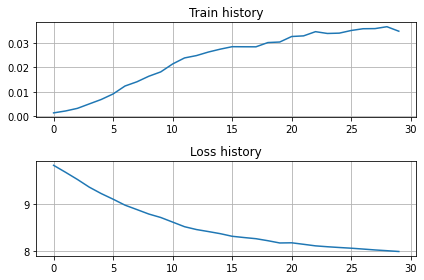

In [11]:
plt.subplot(211)
plt.title("Train history")
plt.grid()
plt.plot(train_history)
plt.subplot(212)
plt.grid()
plt.title("Loss history")
plt.plot(loss_history)
plt.tight_layout()

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

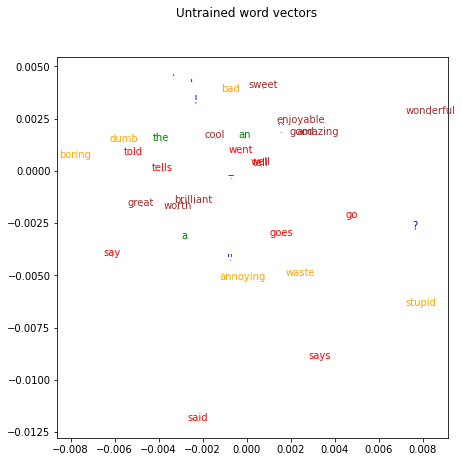

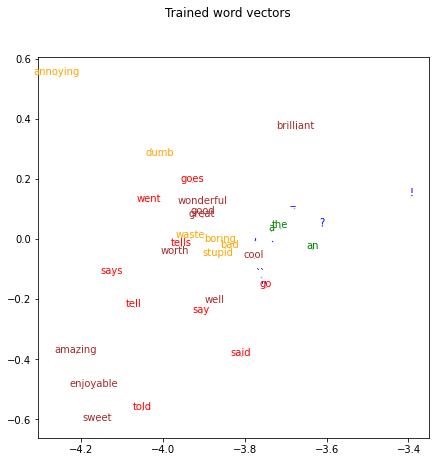

In [12]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0).cpu().detach().numpy()
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")